In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 14
npoly=10

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)


#ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
#fname = ddir + 'HST/n43ca5feq_cal.fits'

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


exposures = [

    #exposure_from_file(ddir + 'n8yj03tgq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(ddir + 'n8yj02wyq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj02x0q_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(fname, SinglePointFit(), crop=wid),
    exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(ddir + 'n8yj03tiq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

]

In [4]:
#exposures[2].target

In [5]:
exposures[0].filter

'F110W'

In [6]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

31 31


In [7]:
exposures[0].filter

'F110W'

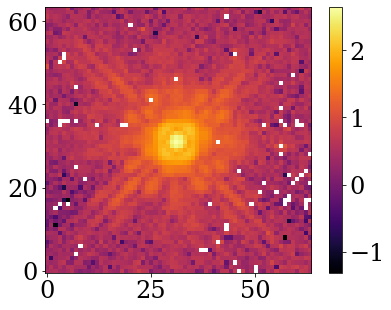

In [8]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

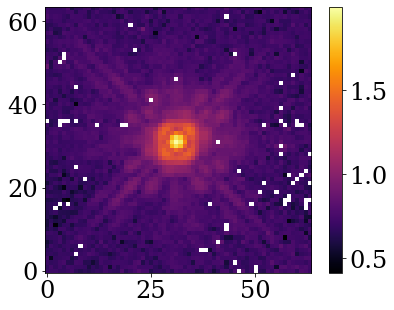

In [9]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [10]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)/nwavels#.at[0].set(1)

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [11]:
params

ModelParams(
  params={
    'fluxes':
    {'n8yj53vfq': f32[]},
    'positions':
    {'n8yj53vfq': f32[2]},
    'spectrum':
    {'U10764_F110W': f32[14]},
    'aberrations':
    {'n8yj53vfq': f32[26]},
    'cold_mask_shift':
    {'global': f32[2]},
    'cold_mask_rot':
    {'global': -45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_shear':
    {'F110W': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'rot':
    0.0,
    'softening':
    2.0
  }
)

In [12]:
print(params.params)

{'fluxes': {'n8yj53vfq': Array(3.4618218, dtype=float32)}, 'positions': {'n8yj53vfq': Array([0., 0.], dtype=float32)}, 'spectrum': {'U10764_F110W': Array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857], dtype=float32)}, 'aberrations': {'n8yj53vfq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'global': Array([6., 6.], dtype=float32)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F110W': -45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432,

In [13]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 2e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*5000, 50),
    "cold_mask_rot": opt(g*300, 120),
    "cold_mask_scale": opt(g*3000, 150),
    "cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*200,100),
    "spectrum": opt(g*1e0, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [14]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [15]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
fishers

{'n8yj53vfq': {'fluxes': Array([[0.]], dtype=float32),
  'positions': Array([[174.23589 , -22.892248],
         [-22.892275, 197.14743 ]], dtype=float32),
  'cold_mask_shift': Array([[404.87473 , -44.637093],
         [-44.637093, 404.81412 ]], dtype=float32),
  'cold_mask_rot': Array([[734.79535]], dtype=float32),
  'cold_mask_scale': Array([[2264183.   ,  -26172.354],
         [ -26172.38 , 2263760.5  ]], dtype=float32),
  'cold_mask_shear': Array([[359.6847  ,  -7.740582],
         [ -7.740575, 359.66974 ]], dtype=float32),
  'aberrations': Array([[ 2.93238610e-02,  4.12470242e-03,  1.78655703e-03,
          -5.85511979e-03,  6.71965769e-03,  8.73156067e-04,
           1.44594652e-03,  1.84669476e-02,  1.44599890e-03,
          -1.17293559e-03,  4.90721641e-03, -4.49971703e-04,
           1.32025480e-02, -1.19843334e-02,  5.11012506e-03,
           3.54817347e-03,  1.15609565e-03, -9.75939212e-04,
          -1.37424292e-02, -6.63635926e-03, -2.31886958e-03,
          -2.52552039e-04

In [17]:
lrs.params

{'aberrations': {'n8yj53vfq': Array([-34.10192  , -77.923386 , -62.620266 , -18.840137 , -17.255295 ,
         -37.248245 , -34.979893 , -12.967634 , -12.495597 , -15.080792 ,
         -27.123495 , -33.09836  ,  -9.070463 ,  -9.670704 , -10.046652 ,
         -10.257064 , -20.138542 , -21.111734 ,  -7.9525914,  -8.73349  ,
          -6.6016364,  -8.423477 ,  -8.264864 , -15.679732 , -16.17496  ,
          -6.1732035], dtype=float32)},
 'cold_mask_rot': {'global': Array(-0.00136092, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([-4.4166040e-07, -4.4174286e-07], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([-0.00278021, -0.00278033], dtype=float32)},
 'cold_mask_shift': {'global': Array([-0.0024699 , -0.00247027], dtype=float32)},
 'fluxes': {'n8yj53vfq': Array(1., dtype=float32)},
 'outer_radius': None,
 'positions': {'n8yj53vfq': Array([-0.00573935, -0.00507235], dtype=float32)},
 'primary_rot': {'F110W': None},
 'primary_scale': {'F110W': None},
 'primary_shear': {'F110W

In [18]:
model

NICMOSModel(
  params={
    'aberrations':
    {'n8yj53vfq': f32[26]},
    'cold_mask_rot':
    {'global': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'global': f32[2]},
    'fluxes':
    {'n8yj53vfq': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'n8yj53vfq': f32[2]},
    'primary_rot':
    {'F110W': f32[]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    f32[],
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'softening':
    f32[],
    'spectrum':
    {'U10764_F110W': f32[14]},
    'spider_width':
    f32[]
  },
  filters={'F110W': f32[244,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None,
          rotation=f32[],
          compression=None,
       

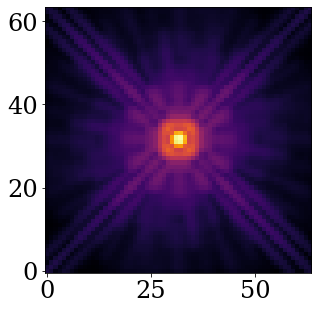

In [19]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [20]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    #if i == 200:
    #    params.set("softening", 0.2)

    #if i == 150:
    #    rc = True
    #    fishers = calc_fishers(model, exposures, paths, recalculate=rc)
    #    lrs = calc_lrs(model, exposures, fishers, paths)

    #params = params.set("spectrum.U10764_F110W", np.abs(params.get("spectrum.U10764_F110W")))
    #params = params.set("spectrum.U10764_F110W", params.get("spectrum.U10764_F110W")/np.sum(params.get("spectrum.U10764_F110W")))

    models.append(params)
    losses.append(loss)


  0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
#model


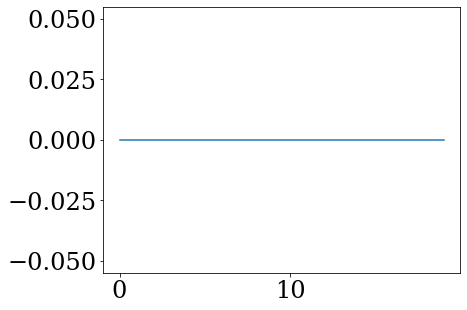

In [22]:
plt.plot(losses[-20:])

8


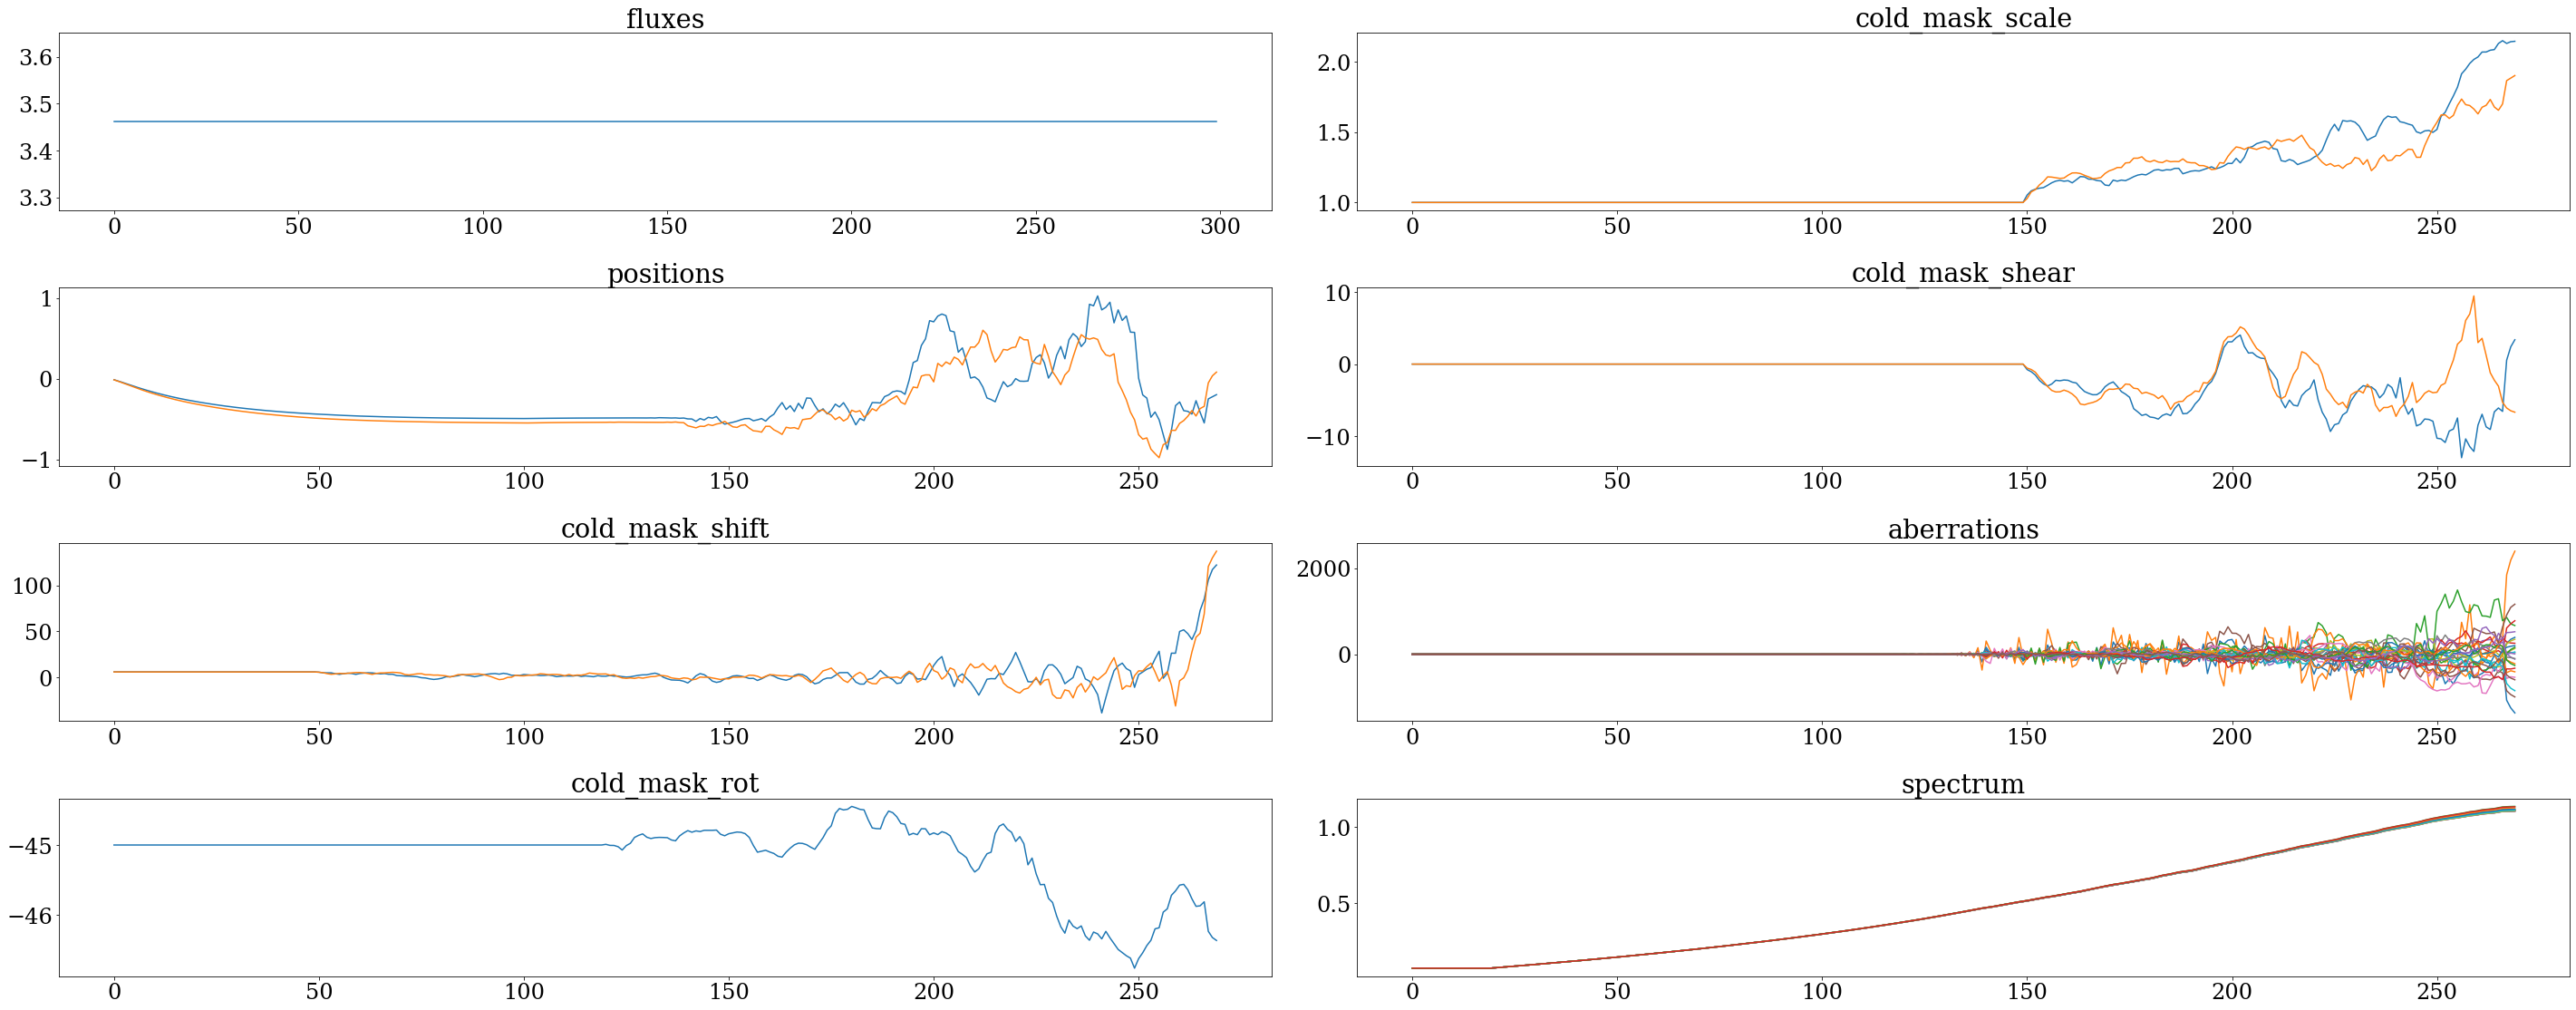

In [23]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope", "spectrum"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [24]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

9.762983e+05, 0.000000e+00


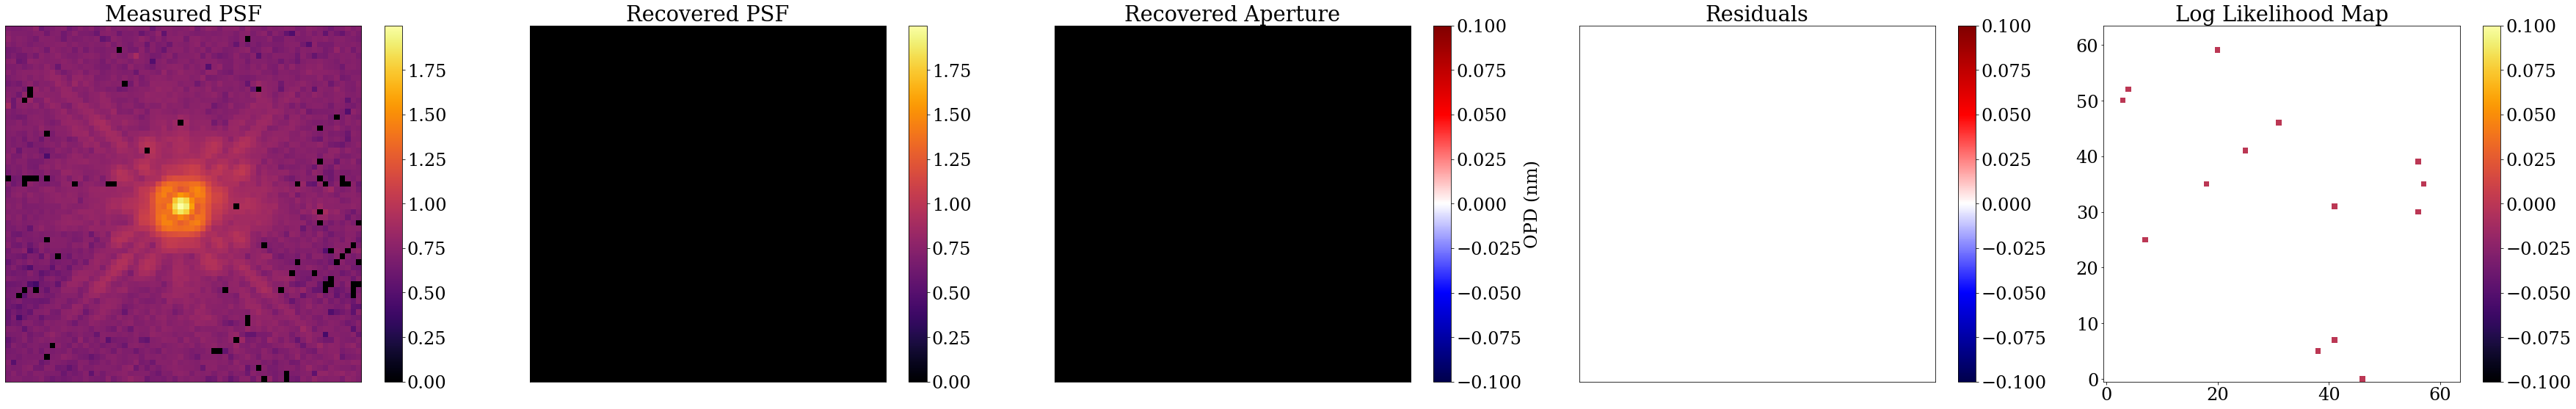

In [25]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.nanmax(np.abs(opd*support_mask))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[3].axvline((wid-1)/2 + params.get(exp.map_param("positions"))[0], color='k',linestyle='--')
axs[3].axhline((wid-1)/2 + params.get(exp.map_param("positions"))[1], color='k',linestyle='--')


lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [26]:
params.get("spectrum.U10764_F110W")

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

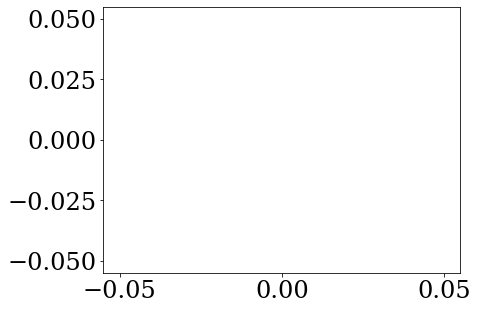

In [27]:
wv = filter_files["F110W"][:,0]/1e10
wmax = np.max(wv)
wmin = np.min(wv)

swv = (wv-wmin)/(wmax-wmin)
spec = dl.PolySpectrum(swv, params.get("spectrum.U10764_F110W"))
plt.plot(swv, spec.weights)

In [28]:
params.params["spectrum"]

{'U10764_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan], dtype=float32)}

In [29]:
#potato

In [30]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
fishers['n8yj53vfq'].keys()

dict_keys(['fluxes', 'positions', 'cold_mask_shift', 'cold_mask_rot', 'cold_mask_scale', 'cold_mask_shear', 'aberrations', 'spectrum'])

In [32]:
np.diag(np.linalg.inv(fishers['n8yj53vfq']['spectrum']/1e5))

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

In [33]:
spectrum_cov = np.linalg.inv(fishers['n8yj53vfq']['spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

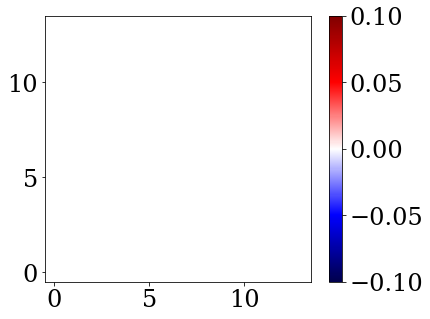

In [34]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()


In [35]:
spectrum_cov

Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, 

In [36]:
params.params['spectrum']

{'U10764_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan], dtype=float32)}

In [37]:
params.get("spectrum.U10764_F110W")/spectrum_err

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

In [38]:
params.params

{'aberrations': {'n8yj53vfq': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32)},
 'cold_mask_rot': {'global': Array(nan, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([nan, nan], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([nan, nan], dtype=float32)},
 'cold_mask_shift': {'global': Array([nan, nan], dtype=float32)},
 'fluxes': {'n8yj53vfq': Array(3.4618218, dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'n8yj53vfq': Array([nan, nan], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'rot': 0.0,
 'scale': 0.0432,
 'secondary_radius': 0.44639999999999996,
 'softening': 2.0,
 'spectrum': {'U10764_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan], dtype=float32)},
 'spider_width': 0.0

Text(0, 0.5, 'Relative Spectral Intensity')

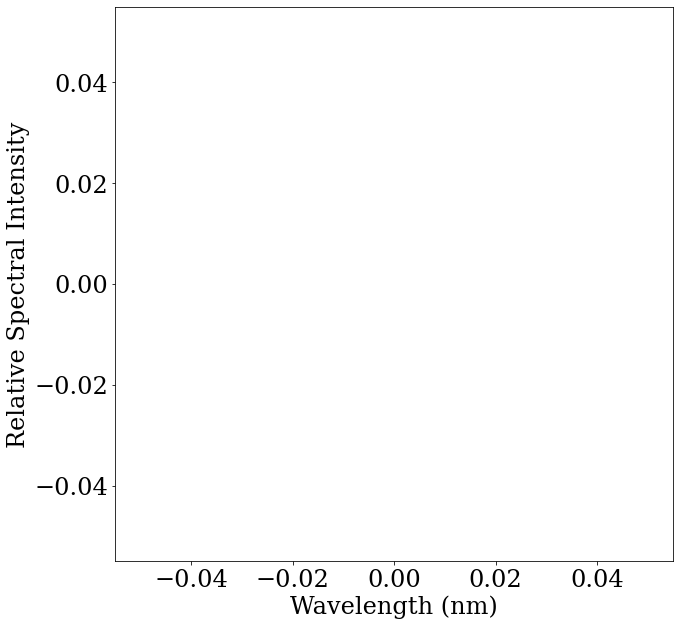

In [39]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = 0#(wmax-wmin)*0.1

wavels = np.linspace(wmin+woff, wmax-woff, nwavels)
#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.errorbar(wavels[1:-1], params.get("spectrum.U10764_F110W")[1:-1], yerr = spectrum_err[1:-1])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [40]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [41]:
import numpy

symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))

LinAlgError: SVD did not converge

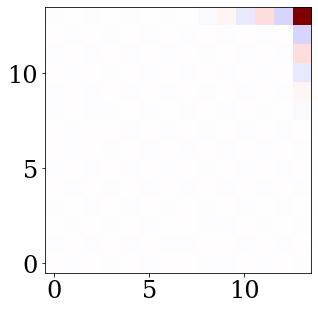

In [ ]:
pdc = nearestPD(symmetric_cov)
plt.imshow(pdc, cmap='seismic', vmin=-np.max(np.abs(pdc)), vmax=np.max(np.abs(pdc)))


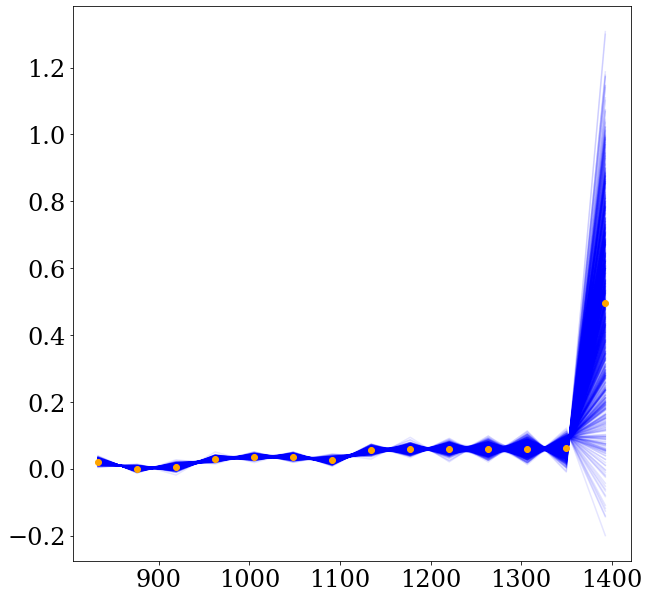

In [ ]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1
wavels = np.linspace(wmin+woff, wmax-woff, nwavels)

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))
    plt.plot(wavels, coeffs, color='b', alpha=0.1, zorder=0)

plt.scatter(wavels, params.get("spectrum.U10764_F110W"), color="orange", zorder=1)


In [ ]:
params.get("spectrum.U10764_F110W")

Array([2.1157231e-02, 7.1397935e-06, 6.0464637e-03, 2.9608114e-02,
       3.5669290e-02, 3.5742212e-02, 2.4572302e-02, 5.5405982e-02,
       5.8833942e-02, 5.9197485e-02, 5.9235446e-02, 5.9339099e-02,
       6.0586996e-02, 4.9459827e-01], dtype=float32)

In [ ]:
spectrum_cov

Array([[ 2.38059947e-05, -1.36515828e-05,  1.62029228e-05,
        -6.14940745e-06,  2.55705027e-06, -1.11149438e-06,
         5.61603088e-07,  7.07830964e-07, -2.63626293e-06,
        -9.69753501e-07,  4.41938346e-06, -5.86063015e-06,
         4.93707284e-06, -1.19348202e-04],
       [-1.36514063e-05,  8.89624425e-06, -1.28629235e-05,
         5.78394292e-06, -2.62164895e-06,  1.06251457e-06,
        -6.39379948e-07, -3.94197457e-07,  1.43680256e-06,
         4.83847657e-07, -3.54017061e-06,  4.44102670e-06,
        -3.59456294e-06,  6.66672931e-05],
       [ 1.62037686e-05, -1.28637121e-05,  2.48654014e-05,
        -1.50682235e-05,  8.45835166e-06, -4.11453448e-06,
         2.43460954e-06, -2.31375736e-07, -1.15956595e-06,
        -1.04821584e-06,  7.59371915e-06, -1.02240538e-05,
         8.42858299e-06, -1.29277774e-04],
       [-6.15373801e-06,  5.78748086e-06, -1.50745855e-05,
         1.29104528e-05, -1.11162853e-05,  6.80797211e-06,
        -4.36642767e-06,  1.32898242e-06, -1.

In [ ]:
len(swv)

71

: 